In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
import networkx as nx
import geopy.distance

In [2]:
## Load necessary data
G = pickle.load(open('data/revised_cleaning_results/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/revised_cleaning_results/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [3]:
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
 

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [4]:
df_nodes

,n,X,Y,geometry,Wkt,degree
8866165,8866165,5.382950,52.262284,"{'type': 'Point', 'coordinates': (5.3829497287...",POINT (5.3829497287695700 52.2622839331948015),2
B8920_B,B8920_B,5.954456,51.202796,"{'type': 'Point', 'coordinates': (5.9544561397...",POINT (5.9544561397793894 51.2027961195344616),2
B58191_A,B58191_A,6.940557,53.320616,"{'type': 'Point', 'coordinates': (6.9405567232...",POINT (6.9405567232651215 53.3206159483904614),2
B53266_A,B53266_A,5.770475,52.707727,"{'type': 'Point', 'coordinates': (5.7704750303...",POINT (5.7704750303644330 52.7077273261975066),2
B49641_B,B49641_B,6.720430,52.252350,"{'type': 'Point', 'coordinates': (6.7204298932...",POINT (6.7204298932146269 52.2523498416338228),2
...,...,...,...,...,...,...
8865818,8865818,4.447912,51.900094,"{'type': 'Point', 'coordinates': (4.4479120307...",POINT (4.4479120307381397 51.9000940107846986),2
8866159,8866159,5.785317,53.042667,"{'type': 'Point', 'coordinates': (5.7853165926...",POINT (5.7853165926755601 53.0426668480593975),2
B19662337_B,B19662337_B,6.390999,53.253098,"{'type': 'Point', 'coordinates': (6.3909988055...",POINT (6.3909988055204376 53.2530979538195126),2
Berth250,Berth250,5.437047,52.535158,"{'type': 'Point', 'coordinates': (5.4370472350...",POINT (5.4370472350224741 52.5351577154749592),2


In [5]:
nodes_to_keep = df_nodes.loc[(df_nodes.degree!=2)|(df_nodes.n.isin(harbour_nodes))]

In [6]:
keep = list(nodes_to_keep.n)+['8866429']

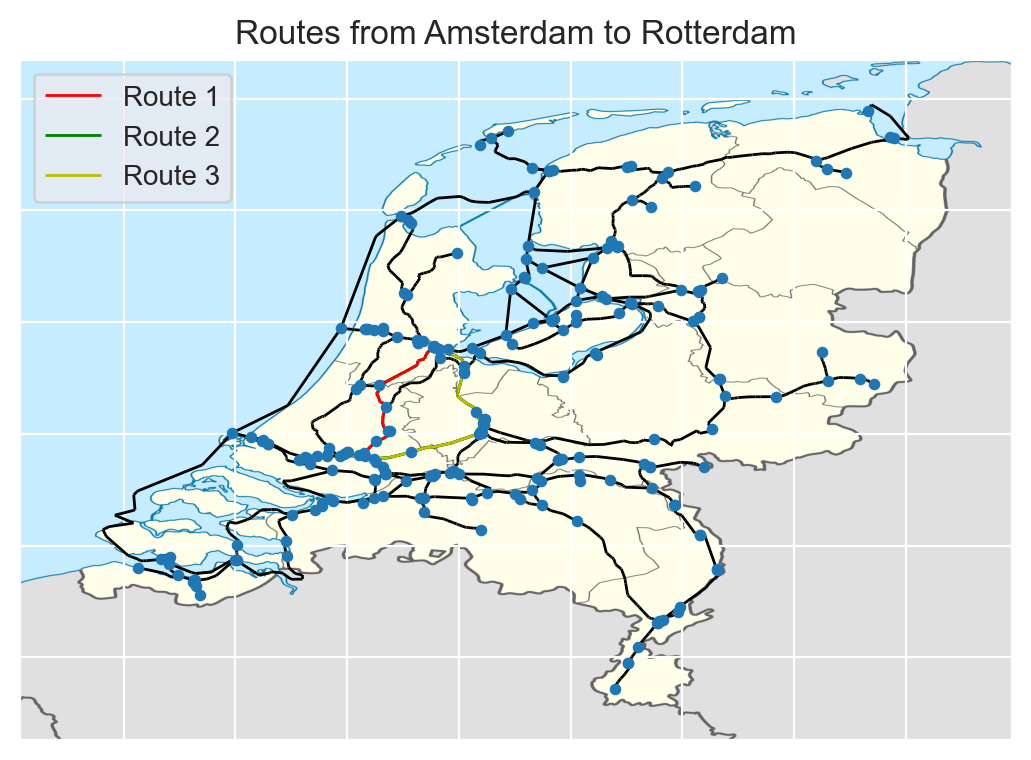

In [7]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
K = G.subgraph(paths[('NLRTM', 'NLAMS', 0)])
nx.draw_networkx_edges(K, pos_dict, edge_color='r', label = 'Route 1')
H = G.subgraph(paths[('NLRTM', 'NLAMS', 1)])
nx.draw_networkx_edges(H, pos_dict, edge_color='g', label = 'Route 2')
H = G.subgraph(paths[('NLRTM', 'NLAMS', 2)])
nx.draw_networkx_edges(H, pos_dict, edge_color='y', label = 'Route 3')

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend()
plt.title('Routes from Amsterdam to Rotterdam')
plt.show()

## Determine additional nodes based on network without dead ends

In [8]:
H = nx.k_core(G, k=2)

In [9]:
pos_dict = {}

for node in H.nodes:
    pos_dict[node] = (H.nodes[node]['X'], H.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(H)
df_nodes = pd.DataFrame.from_dict(dict(H.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: H.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: H.degree[x])
df_nodes['degree'] = H.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])
nodes_to_keep = df_nodes.loc[(df_nodes.degree != 2) | (df_nodes.n.isin(harbour_nodes))]
keep = list(nodes_to_keep.n) + ['8866429']

In [12]:
harbour_nodes_in_H = list(set(df_nodes.n.to_list())&set(df_h.harbour_node))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


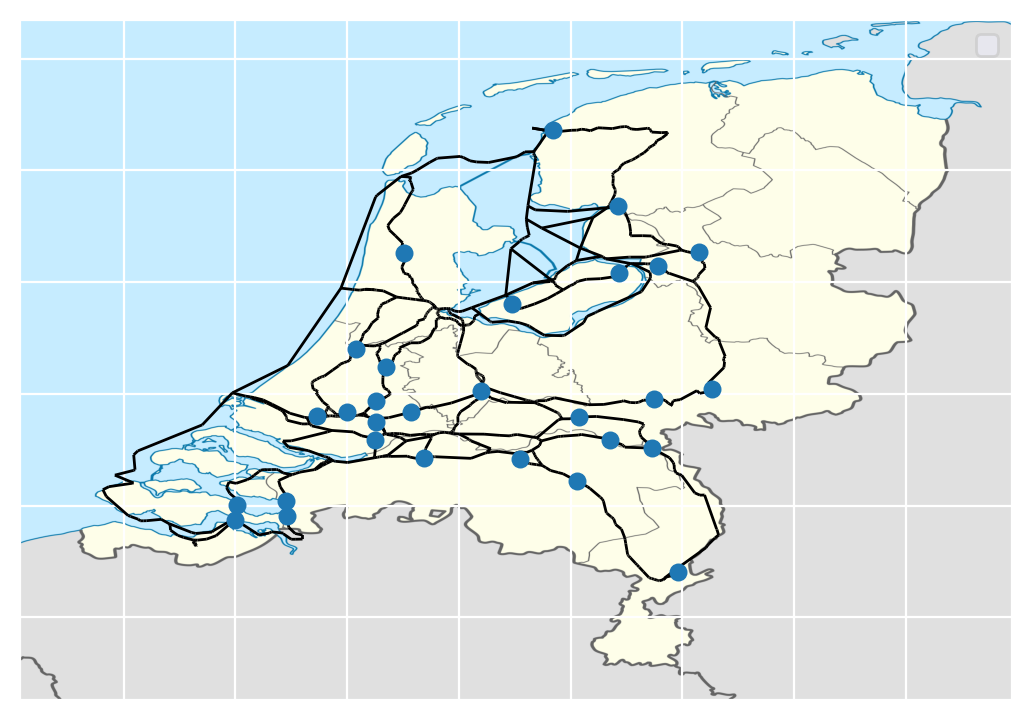

In [13]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(H, pos_dict)
nx.draw_networkx_nodes(H, pos_dict, harbour_nodes_in_H, node_size=30)
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53

ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend()
plt.show()

In [27]:
harbour_nodes_in_H = list(set(df_nodes.n.to_list())&set(df_h.harbour_node))

In [28]:
# for node, degree in H.degree():
#     if degree==2:
#         edges = H.edges(node)
#         print(edges)
#         edges = list(edges.__iter__())
#         print(edges)
#         length=0
#         for j in edges:
#             length += nx.dijkstra_path_length(H, j[0], j[1], weight='length_m')
#         print(length)
#         break

In [29]:
def simplifyGraph(G):
    """ Loop over the graph until all nodes of degree 2 have been removed and their incident edges fused """
    g = G.copy()

    while any(degree==2 for _, degree in g.degree):

        g0 = g.copy() #<- simply changing g itself would cause error `dictionary changed size during iteration`
        for node, degree in g.degree():
            if degree==2:
                edges = g.edges(node)
                edges = list(edges.__iter__())
                origin_and_dest = [item for t in edges for item in t if item != node]
                total_length=0
                for j in edges:
                    total_length += nx.dijkstra_path_length(H, j[0], j[1], weight='length_m')
                g0.remove_node(node)
                g0.add_weighted_edges_from([(origin_and_dest[0], origin_and_dest[1], total_length)], weight='length_m')
                break
        g = g0

    return g

In [30]:
H = simplifyGraph(H)

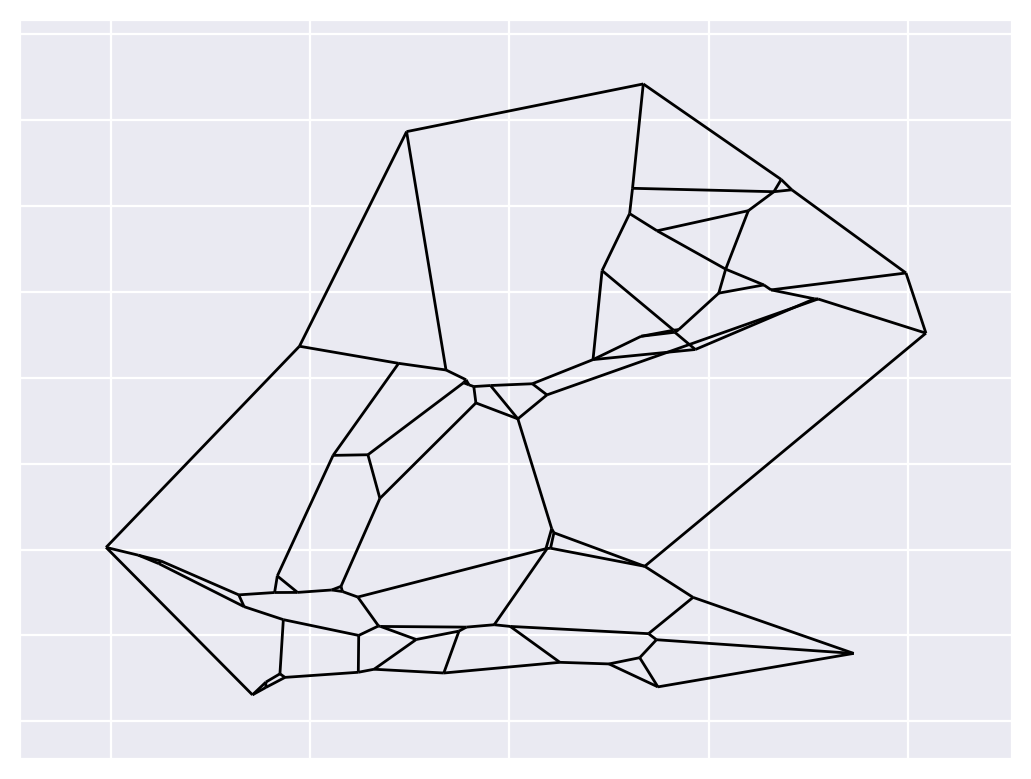

In [31]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(H, pos_dict)

## Simplify original graph

In [8]:
# create list to store new edges
new_edges = []

#loop over all routes
for key, route in paths.items():
    path_length = 0
    print(key)
    # store all nodes that are still in G in the right order

    new_route = []
    for node in route:
        if node in keep:
            new_route.append(node)

    # change path to new route already
    paths[key] = new_route
    print(new_route)
    sub_trips = [new_route[i:(i+2)] for i in range(len(new_route)-1)]
    print(sub_trips)
    started_from = new_route[0]
    for sub_trip in sub_trips:
        origin=sub_trip[0]
        destination=sub_trip[1]
        path_length += nx.dijkstra_path_length(G, origin, destination, weight='length_m')
        if destination in new_route:
            if G.has_edge(started_from, destination):
                started_from = destination
                path_length = 0
            else:
                new_edges.append((origin, destination, path_length))
                started_from = destination
                path_length = 0

    # # create a dict with routes between node to keep to next node to keep
    # sub_routes = {i:[] for i in range(len(new_route)-1)}
    # print(sub_routes)
    # # current sub route
    # r = 0
    # # loop over all nodes of route
    # for i, node in enumerate(route):
    #     # divide nodes over different sub_routes
    #     sub_routes[r].append(node)
    #     # if node final node of sub_route is encountered: add this node to next route and fill this one from now on
    #     if (node in keep) and (i>0) and (node != route[-1]):
    #         sub_routes[r+1].append(node)
    #         r+=1
    # for sub_route in sub_routes.values():
    #     path_length = 0
    #     # print(sub_route)
    #     if len(sub_route) > 2:
    #         path_length = 0
    #         for j in range(len(sub_route)-1):
    #             path_length += nx.dijkstra_path_length(G, sub_route[j], sub_route[j+1], weight='length_m')
    #         new_edges.append((sub_route[0], sub_route[-1], path_length))
    #     else:
    #         path_length += nx.dijkstra_path_length(G, sub_route[0], sub_route[1], weight='length_m')
    #         new_edges.append((sub_route[0], sub_route[-1], path_length))
    # for i in range(len(new_route)-1):
    #     new_edges.append((new_route[i],new_route[i+1],path_l))


('NLABL', 'NLRTM', 0)
['8866686', '8865140', '8867500', '8863742', '8864009', '8863306']
[['8866686', '8865140'], ['8865140', '8867500'], ['8867500', '8863742'], ['8863742', '8864009'], ['8864009', '8863306']]
('NLAER', 'NLLEY', 0)
['8864005', '8864526', '8862690', '8863709']
[['8864005', '8864526'], ['8864526', '8862690'], ['8862690', '8863709']]
('NLAER', 'NLNIE', 0)
['8864005', '8864076', '8867515', '8864384', '8862592', '8867046', '8863360', '8865214', '8867538']
[['8864005', '8864076'], ['8864076', '8867515'], ['8867515', '8864384'], ['8864384', '8862592'], ['8862592', '8867046'], ['8867046', '8863360'], ['8863360', '8865214'], ['8865214', '8867538']]
('NLAER', 'NLRTM', 0)
['8864005', '8864076', '8867515', '8864384', '8862592', '8867046', '8863360', '8865214', '8867538', '8867374', '8863742', '8864009', '8863306']
[['8864005', '8864076'], ['8864076', '8867515'], ['8867515', '8864384'], ['8864384', '8862592'], ['8862592', '8867046'], ['8867046', '8863360'], ['8863360', '8865214'], 

In [9]:
#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')


# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [10]:
df_nodes

,n,X,Y,geometry,Wkt,degree
8866165,8866165,5.382950,52.262284,"{'type': 'Point', 'coordinates': (5.3829497287...",POINT (5.3829497287695700 52.2622839331948015),2
B8920_B,B8920_B,5.954456,51.202796,"{'type': 'Point', 'coordinates': (5.9544561397...",POINT (5.9544561397793894 51.2027961195344616),2
B58191_A,B58191_A,6.940557,53.320616,"{'type': 'Point', 'coordinates': (6.9405567232...",POINT (6.9405567232651215 53.3206159483904614),2
B53266_A,B53266_A,5.770475,52.707727,"{'type': 'Point', 'coordinates': (5.7704750303...",POINT (5.7704750303644330 52.7077273261975066),2
B49641_B,B49641_B,6.720430,52.252350,"{'type': 'Point', 'coordinates': (6.7204298932...",POINT (6.7204298932146269 52.2523498416338228),2
...,...,...,...,...,...,...
8865818,8865818,4.447912,51.900094,"{'type': 'Point', 'coordinates': (4.4479120307...",POINT (4.4479120307381397 51.9000940107846986),2
8866159,8866159,5.785317,53.042667,"{'type': 'Point', 'coordinates': (5.7853165926...",POINT (5.7853165926755601 53.0426668480593975),2
B19662337_B,B19662337_B,6.390999,53.253098,"{'type': 'Point', 'coordinates': (6.3909988055...",POINT (6.3909988055204376 53.2530979538195126),2
Berth250,Berth250,5.437047,52.535158,"{'type': 'Point', 'coordinates': (5.4370472350...",POINT (5.4370472350224741 52.5351577154749592),2


In [11]:
G = G.subgraph(keep)
G = nx.Graph(G)
G.add_weighted_edges_from(new_edges,'length_m')

In [12]:
df_nodes.loc[df_nodes.n=='30985843']

,n,X,Y,geometry,Wkt,degree
30985843,30985843,4.780852,52.970492,"{'type': 'Point', 'coordinates': (4.7808518813...",POINT (4.7808518813762699 52.9704921320969007),2


In [13]:
excluded_links = df_links.loc[(df_links.target.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))|(df_links.source.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))]
excluded_links = list(zip(list(excluded_links.source),list(excluded_links.target)))

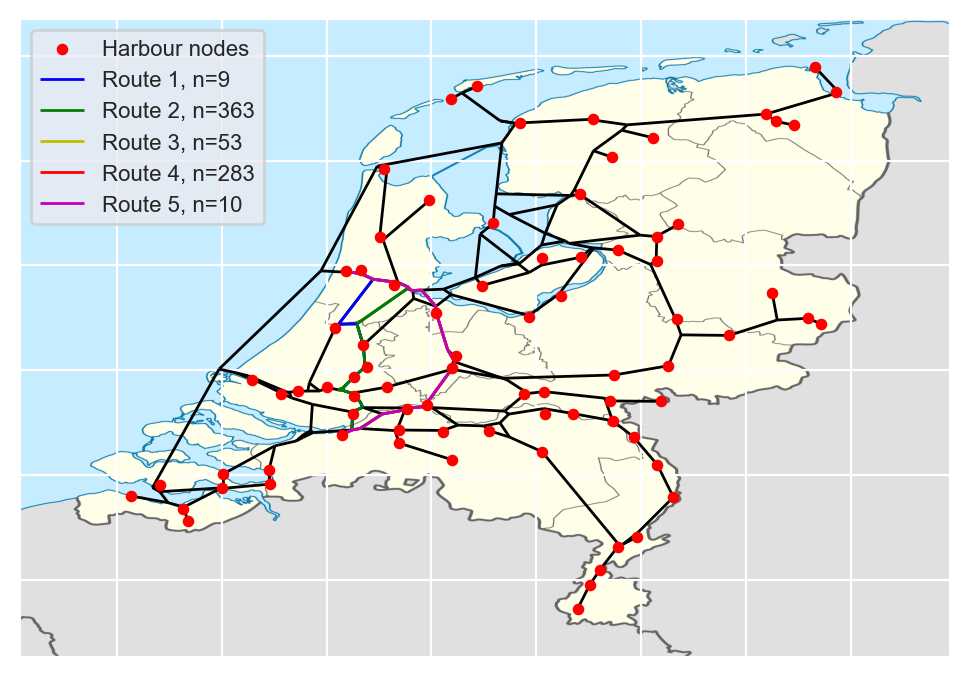

In [14]:
fig, ax = plt.subplots(dpi=200, figsize=(6,6))
nx.draw_networkx_edges(G, pos_dict)
# nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10, node_color='Blue', label='Intersections')
nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='r', label='Harbour nodes')

K = G.subgraph(paths[('NLIJM', 'NLMOE', 0)])
nx.draw_networkx_edges(K, pos_dict, edge_color='b', label = 'Route 1, n=9')
H = G.subgraph(paths[('NLIJM', 'NLMOE', 1)])
nx.draw_networkx_edges(H, pos_dict, edge_color='g', label = 'Route 2, n=363')
H = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
nx.draw_networkx_edges(H, pos_dict, edge_color='y', label = 'Route 3, n=53')
X = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
nx.draw_networkx_edges(X, pos_dict, edge_color='r', label = 'Route 4, n=283')
Z = G.subgraph(paths[('NLIJM', 'NLMOE', 2)])
nx.draw_networkx_edges(Z, pos_dict, edge_color='m', label = 'Route 5, n=10')

# nx.draw_networkx_nodes(G, pos_dict, ['8862614', '8860852', '8861819','8867031','8867600', '8860933'], node_color='r', node_size=20)
# nx.draw_networkx_edges(G,pos_dict,excluded_links,edge_color='r', label='Edges not considered for splitting')
# nx.draw_networkx_nodes(G, pos_dict, ['22638120'], node_color='g', node_size=10)
img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
plt.legend(fontsize=8)
plt.show()

In [14]:
# store this network with direct connections for later use
pickle.dump(G, open('data/network_cleaned_final.p', 'wb'))
pickle.dump(paths, open('data/final_paths.p', 'wb'))

In [15]:
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [16]:
df_links.loc[(df_links.source=='8860852')]

,source,target,PushedDepth,WidePushedWidth,SeaFairingHeight,EndJunctionId,PushedWidth,length_deg,CoupledLength,length,...,StartJunctionId,Code,GeneralWidth,Classification,SeaFairingLength,Id_navigability,SeaFairingWidth,SeaFairingDepth,geometry,GeneralHeight
76,8860852,8861819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,8860852,8866305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_links

,source,target,PushedDepth,WidePushedWidth,SeaFairingHeight,EndJunctionId,PushedWidth,length_deg,CoupledLength,length,...,StartJunctionId,Code,GeneralWidth,Classification,SeaFairingLength,Id_navigability,SeaFairingWidth,SeaFairingDepth,geometry,GeneralHeight
0,8863207,8861546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8863207,8860631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8867083,8861380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8867083,8862801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8866775,11309058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,8863755,8863105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,8863105,8862858,NaN,NaN,NaN,8862858,NaN,NaN,NaN,0.006014,...,8863105,VI_C,NaN,CEMT,NaN,29513518.0,NaN,NaN,"{'type': 'LineString', 'coordinates': ((3.8197...",NaN
275,8867403,8860563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,8862592,8867046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# give edges a new attribute split
nx.set_edge_attributes(G, 0, 'split')

In [19]:
# first inserted node gets ID 100 and from there upwards
id_count = 100
inserted = []
nodes_to_add = 20
while len(inserted) < nodes_to_add:
    # update dataframes
    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

    exluded_nodes = ['8862614', '8860852', '8861819','8867031','8867600', '8860933']
    # find the longest link source and origin, except for the two links that cross the sea
    df_links = df_links.loc[(~df_links.source.isin(exluded_nodes))|(~df_links.target.isin(exluded_nodes))]
    df_links.reset_index(inplace=True, drop=True)
    to_split = df_links.loc[df_links.length_m == max(df_links.length_m)]
    to_split.reset_index(inplace=True, drop=True)
    # identify source/targets points
    points = list(to_split.loc[(to_split.source.str.len()>5)].source.values) + list(to_split.loc[(to_split.target.str.len()>5)].target.values)
    print(points)
    org_source = points[0]
    org_target = points[1]
    print('Largest link found', to_split.length_m[0], 'original link:', org_source, org_target, 'splitted', to_split.split[0], 'times before.')

    # determine original length, also works if link has been split earlier
    original_length = 0
    for j in to_split.length_m:
        original_length += j

    org_source_data = df_nodes.loc[df_nodes.n == org_source]
    org_target_data = df_nodes.loc[df_nodes.n == org_target]

    #if never split: split in two, if split once: split in three, etc.
    split_in = round(to_split.split[0] + 2)

    #find new X and Y positions
    x_set = np.linspace(org_source_data.X.values[0], org_target_data.X.values[0], (split_in+1))
    y_set = np.linspace(org_source_data.Y.values[0], org_target_data.Y.values[0], (split_in+1))

    # remove old link(s)
    for j in to_split.index:
        G.remove_edge(to_split.source[j], to_split.target[j])
        print('Link removed between', to_split.source[j], to_split.target[j])
    #if split before, remove earlier inserted points
    points_to_remove = list(to_split.loc[(to_split.source.str.len()<5)].source.values) + list(to_split.loc[(to_split.target.str.len()<5)].target.values)
    if points_to_remove:
        for j in set(points_to_remove):
            G.remove_node(j)
            print("Node", j, "removed and replaced by", split_in-1,"intermediate nodes")
            inserted.remove(j)


    # add nodes, except for outsides that already exist
    added_ids = []
    print(x_set)
    print(y_set)
    for index_pos, j in enumerate(x_set):
        if (index_pos != 0) and (index_pos != (len(x_set)-1)):
            G.add_node(str(id_count), X = x_set[index_pos], Y = y_set[index_pos])
            print('Node inserted with id', id_count, 'at (x,y):', x_set[index_pos], y_set[index_pos])
            added_ids.append(str(id_count))
            inserted.append(str(id_count))
            id_count += 1

    #finally, add edges
    nodes_sequence = [org_source] + added_ids + [org_target]
    print(nodes_sequence)
    for j in range(len(nodes_sequence)-1):
        G.add_edge(nodes_sequence[j],nodes_sequence[j+1], length_m=(original_length/split_in), split = int(to_split.split[0]+1))
        print("Link added between", nodes_sequence[j], nodes_sequence[j+1], "with length", (original_length/split_in))

    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
else:
    print("There were", len(inserted), "nodes added, the longest remaining link is now:", df_links.length_m.max())

['8862419', '8861681']
Largest link found 75895.64343792459 original link: 8862419 8861681 splitted 0 times before.
Link removed between 8862419 8861681
[6.5965198  6.26537212 5.93422443]
[53.22178428 53.19608016 53.17037604]
Node inserted with id 100 at (x,y): 6.2653721173492 53.19608015887845
['8862419', '100', '8861681']
Link added between 8862419 100 with length 37947.821718962296
Link added between 100 8861681 with length 37947.821718962296
['8864319', '8865990']
Largest link found 68798.30264237327 original link: 8864319 8865990 splitted 0 times before.
Link removed between 8864319 8865990
[5.89694168 5.71230488 5.52766808]
[51.16388944 51.38728775 51.61068606]
Node inserted with id 101 at (x,y): 5.712304877163126 51.38728774858195
['8864319', '101', '8865990']
Link added between 8864319 101 with length 34399.15132118663
Link added between 101 8865990 with length 34399.15132118663
['8863207', '8860631']
Largest link found 62033.758287885365 original link: 8863207 8860631 splitted

In [20]:
# fix insertion of additional nodes in route!
for route, path in paths.items():
    new_route = [path[0]]
    for node_index in range(len(path)-1):
        p = nx.dijkstra_path(G, path[node_index], path[node_index+1])
        new_route += p[1:]
    paths[route] = new_route

In [21]:
# retrieve data again
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

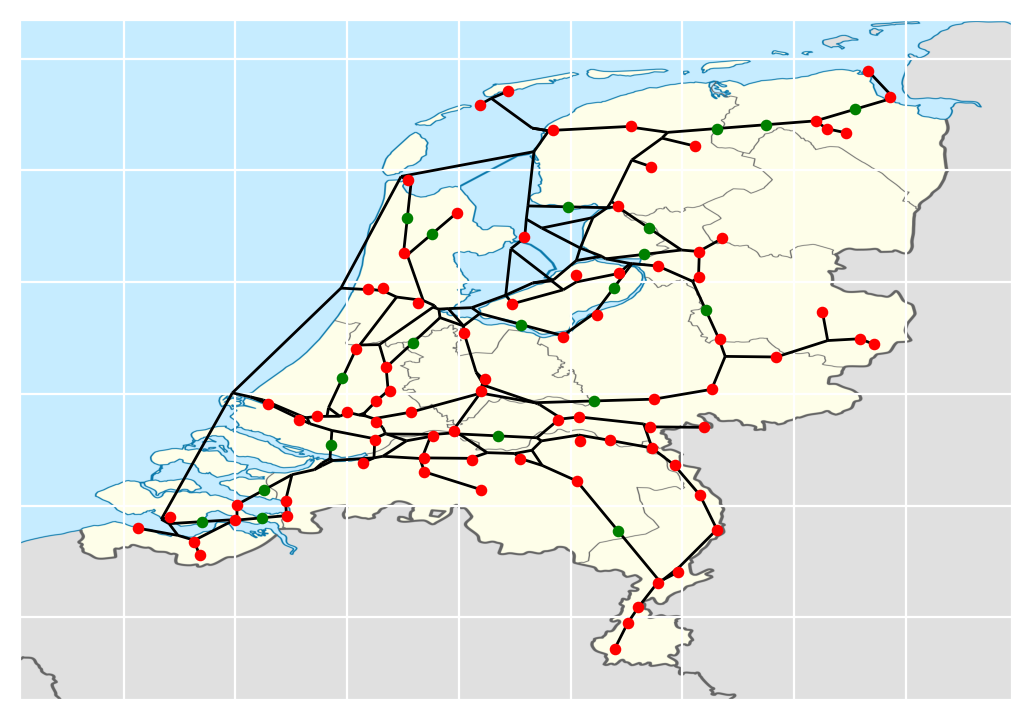

In [22]:
#check if it worked
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)

nx.draw_networkx_nodes(G, pos_dict, harbour_nodes, node_size=10, node_color='r', label='Harbour nodes')
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=10, node_color='g', label='Inserted nodes')

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])
# nx.draw_networkx_nodes(G, pos_dict, ['8866429'], node_size=10, node_color='g')

## Add intersections?

In [99]:
df_nodes

,n,X,Y,geometry,Wkt,degree
8863207,8863207,5.872436,51.976705,"{'type': 'Point', 'coordinates': (5.8724362593...",POINT (5.8724362593158004 51.9767047069275989),2
8867083,8867083,4.224534,51.522179,"{'type': 'Point', 'coordinates': (4.2245335490...",POINT (4.2245335490135298 51.5221793441428062),2
8866775,8866775,5.275508,51.710912,"{'type': 'Point', 'coordinates': (5.2755082297...",POINT (5.2755082297752702 51.7109120927941959),2
8864912,8864912,6.045951,52.503904,"{'type': 'Point', 'coordinates': (6.0459513950...",POINT (6.0459513950439812 52.5039040472422016),3
22638327,22638327,5.853965,51.851442,"{'type': 'Point', 'coordinates': (5.8539653841...",POINT (5.8539653841948196 51.8514420885142968),1
...,...,...,...,...,...,...
116,116,5.175535,51.812524,NaN,NaN,2
117,117,5.826475,52.624314,NaN,NaN,2
118,118,6.375755,53.204648,NaN,NaN,2
119,119,6.154990,53.187512,NaN,NaN,2


In [100]:
df_nodes['n']=df_nodes.index

In [101]:
harbours_ongoing_routes = df_nodes.loc[((df_nodes.n.isin(harbour_nodes))&(df_nodes.degree>1))|(df_nodes.n.str.len()<4)|(df_nodes.n.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))]

In [102]:
harbours_ongoing_routes

,n,X,Y,geometry,Wkt,degree
8863207,8863207,5.872436,51.976705,"{'type': 'Point', 'coordinates': (5.8724362593...",POINT (5.8724362593158004 51.9767047069275989),2
8867083,8867083,4.224534,51.522179,"{'type': 'Point', 'coordinates': (4.2245335490...",POINT (4.2245335490135298 51.5221793441428062),2
8866775,8866775,5.275508,51.710912,"{'type': 'Point', 'coordinates': (5.2755082297...",POINT (5.2755082297752702 51.7109120927941959),2
8862776,8862776,4.786350,51.918784,"{'type': 'Point', 'coordinates': (4.7863500837...",POINT (4.7863500837871804 51.9187839838017098),2
8862614,8862614,3.668687,51.439072,"{'type': 'Point', 'coordinates': (3.6686865135...",POINT (3.6686865135070996 51.4390721874277972),3
...,...,...,...,...,...,...
116,116,5.175535,51.812524,NaN,NaN,2
117,117,5.826475,52.624314,NaN,NaN,2
118,118,6.375755,53.204648,NaN,NaN,2
119,119,6.154990,53.187512,NaN,NaN,2


In [103]:
intersection_df = df_nodes.loc[(df_nodes.degree>2)&(~df_nodes.n.isin(harbour_nodes))]

In [104]:
def find_nearest_harbour(lon, lat, selected):
    harbours = df_nodes.loc[((df_nodes.n.isin(harbour_nodes))&(df_nodes.degree>1))|(df_nodes.n.str.len()<4)|(df_nodes.n.isin(['8862614', '8860852', '8861819','8867031','8867600', '8860933']))|(df_nodes.n.isin(selected))]
    x = lon
    y = lat
    dev = 0.5

    #find nodes within deviation
    #select nodes near
    selection = harbours.loc[(harbours.X.between(x-dev, x+dev)) & (harbours.Y.between(y-dev, y+dev))]

    # in some areas there are very few nodes, therefore iteratively increase range to look for nodes until at least one is found

    while len(selection) == 0:
        dev+=0.5
        selection = harbours.loc[(harbours.X.between(x-dev, x+dev)) & (harbours.Y.between(y-dev, y+dev))].index

    selection['dist'] = selection.apply(lambda m : (geopy.distance.geodesic((m.X,m.Y),(lon,lat))), axis=1)

    return selection.dist.min()


In [117]:
selected = []
while len(selected) < 20:
    intersection_df['dist_nearest_harbour'] = intersection_df.apply(lambda m: (find_nearest_harbour(m.X, m.Y, selected)), axis=1)
    faraway = intersection_df.sort_values('dist_nearest_harbour', ascending=False).head(1).n.to_list()
    selected += faraway

C:\Users\Fabia\AppData\Local\Temp\ipykernel_13748\1304717547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['dist_nearest_harbour'] = intersection_df.apply(lambda m: (find_nearest_harbour(m.X, m.Y, selected)), axis=1)
C:\Users\Fabia\AppData\Local\Temp\ipykernel_13748\1304717547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['dist_nearest_harbour'] = intersection_df.apply(lambda m: (find_nearest_harbour(m.X, m.Y, selected)), axis=1)
C:\Users\Fabia\AppData\Local\Temp\

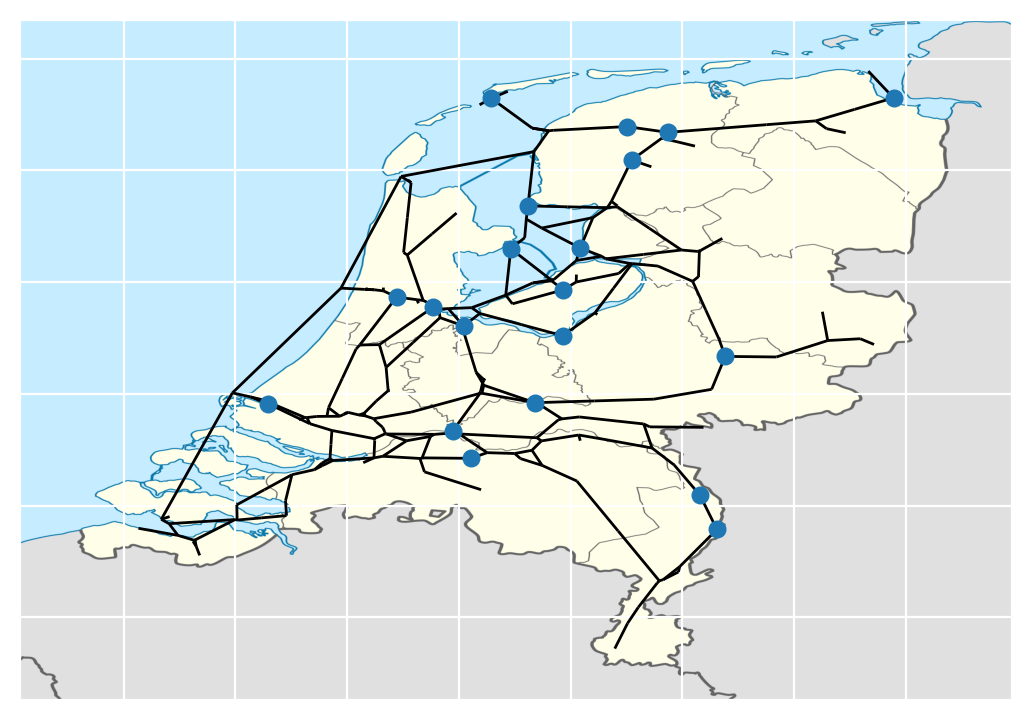

In [119]:
fig, ax = plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, selected, node_size=30)

img = plt.imread("data/NL_map.png")
x1, x2, y1, y2 = 3.566619, 6.944693, 50.860830, 53.444274
z = 0.53
ax.imshow(img, extent=[x1-z, x2+z, y1-z+0.3, y2+z-0.3])

In [120]:
selected

['8865462',
 '8863114',
 '8860563',
 '8865887',
 '8861447',
 '8864526',
 '8860631',
 '8862048',
 '8863762',
 '8861611',
 '8861681',
 '8868065',
 '8863336',
 '8867910',
 '8860623',
 '8864952',
 '8865186',
 '8860918',
 '8864915',
 '8862907']

## Final step: test new network with optimisation

In [23]:
from random_vessel_generator import random_vessel_generator
from flow_computation import flow_computation
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from visualize_placement import visualize_placement

In [24]:
#generate random data
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)
flows = flow_computation(df_random1)

## Run first stage FRLM
df_b, df_g, df_eq_fq = first_stage_frlm(50000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted)

## Run second stage FRLM
optimal_facilities, optimal_flows, non_zero_flows, supported_flow = second_stage_frlm(100, 10, 5, df_g, df_b, df_eq_fq)

visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)

ValueError: too many values to unpack (expected 3)